In [2]:
import pandas as pd
from pathlib import Path
import sys
import numpy as np

# from data_preprocessing.preprocessing import preprocessing
import sys
sys.path.append('/content/drive/MyDrive/DSA4263-Project/eda_ftr_eng')  # just the folder path
import EDA  # now it can find EDA.py as a module
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [3]:
preprocessed_df = pd.read_csv('/content/drive/MyDrive/DSA4263-Project/Data/Processed/processed_df.csv', encoding='latin-1')


In [4]:
df = EDA.eda(preprocessed_df)

/content/drive/MyDrive/DSA4263-Project/eda_ftr_eng/EDA.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: replace_empty_values(x))


In [5]:
df.head(5)

,Job Title,Department,Range_of_Salary,Profile,Job_Description,Requirements,Job_Benefits,Telecomunication,Comnpany_Logo,Type_of_Employment,Experience,Qualification,Type_of_Industry,Operations,Fraudulent,City,Salary_Specified,City_Specified
0,marketing intern,marketing,0.000064,"['food52', 'weve', 'created', 'groundbreaking'...","['food52', 'fastgrowing', 'james', 'beard', 'a...","['experience', 'content', 'management', 'syste...",[],0,1,other,internship,Unspecified,Unspecified,marketing,0,new york,False,True
2,commissioning machinery assistant cma,Unspecified,0.000064,"['valor', 'service', 'provides', 'workforce', ...","['client', 'located', 'houston', 'actively', '...","['implement', 'precommissioning', 'commissioni...",[],0,1,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,0,wever,False,True
3,account executive washington dc,sales,0.000064,"['passion', 'improving', 'quality', 'life', 'g...","['company', 'esri', 'Ã¢', 'environmental', 'sy...","['educationÃ¢', 'bachelorÃ¢s', 'masterÃ¢s', 'g...","['culture', 'anything', 'corporateÃ¢we', 'coll...",0,1,fulltime,midsenior level,bachelors degree,computer software,sales,0,washington,False,True
4,bill review manager,Unspecified,0.000064,"['spotsource', 'solution', 'llc', 'global', 'h...","['job', 'title', 'itemization', 'review', 'man...","['qualificationsrn', 'license', 'state', 'texa...","['full', 'benefit', 'offered']",0,1,fulltime,midsenior level,bachelors degree,hospital health care,health care provider,0,fort worth,False,True
5,accounting clerk,Unspecified,0.000064,[],"['job', 'overviewapex', 'environmental', 'cons...",[],[],0,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,0,Unspecified,False,False


In [6]:
df.columns

Index(['Job Title', 'Department', 'Range_of_Salary', 'Profile',
       'Job_Description', 'Requirements', 'Job_Benefits', 'Telecomunication',
       'Comnpany_Logo', 'Type_of_Employment', 'Experience', 'Qualification',
       'Type_of_Industry', 'Operations', 'Fraudulent', 'City',
       'Salary_Specified', 'City_Specified'],
      dtype='object')

## Encodoing + Embedding

In [7]:
from sentence_transformers import SentenceTransformer

columns_for_embedding = ['Job Title', 'Profile', 'Department', 'Job_Description', 'Requirements', 'Job_Benefits', 'Type_of_Industry', 'Operations','City']
categorical_columns = ['Type_of_Employment','Experience', 'Qualification' ]

model = SentenceTransformer('all-MiniLM-L6-v2')
df = df.reset_index(drop=True) #need to do this
for col in columns_for_embedding:
    print(f"Embedding column: {col}")
    df[f"{col}_embed"] = list(model.encode(df[col].fillna("")))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding column: Job Title
Embedding column: Profile
Embedding column: Department
Embedding column: Job_Description
Embedding column: Requirements
Embedding column: Job_Benefits
Embedding column: Type_of_Industry
Embedding column: Operations
Embedding column: City


In [8]:
def simplify_qualification(q):
    if pd.isna(q) or q in ["unspecified", "other"]:
        return "unspecified"
    elif q in ["high school or equivalent", "some high school coursework", "vocational hs diploma"]:
        return "high school"
    elif q in ["vocational", "vocational degree", "certification", "professional"]:
        return "vocational / certification/ professional"
    elif q == "some college coursework completed":
        return "some college"
    elif q == "associate degree":
        return "associate degree"
    elif q == "bachelors degree":
        return "bachelor's degree"
    elif q == "masters degree":
        return "master's degree"
    elif q == "doctorate":
        return "doctorate"
    else:
        return "unspecified"

def simplify_employment_type(q):
    if pd.isna(q) or q in ["other", "unknown"]:
        return "unspecified"
    else:
        return q

def simplify_experience(q):
    if pd.isna(q) or q in ["not applicable", "unknown"]:
        return "unspecified"
    else:
        return q

df['Qualification'] = df['Qualification'].apply(simplify_qualification)
df['Type_of_Employment'] = df['Type_of_Employment'].apply(simplify_employment_type)
df['Experience'] = df['Experience'].apply(simplify_experience)

In [9]:
df_aft_str_embed = df.drop(columns_for_embedding, axis=1)

In [10]:
# One-Hot Encode
df_aft_enc = pd.get_dummies(df_aft_str_embed, columns=categorical_columns, drop_first=True)

# Get only the one-hot columns that actually exist in the final DataFrame
one_hot_encode_cols = [col for col in df_aft_enc.columns if any(col.startswith(cat + '_') for cat in categorical_columns)] #to be used later

In [11]:
df_aft_enc.columns

Index(['Range_of_Salary', 'Telecomunication', 'Comnpany_Logo', 'Fraudulent',
       'Salary_Specified', 'City_Specified', 'Job Title_embed',
       'Profile_embed', 'Department_embed', 'Job_Description_embed',
       'Requirements_embed', 'Job_Benefits_embed', 'Type_of_Industry_embed',
       'Operations_embed', 'City_embed', 'Type_of_Employment_contract',
       'Type_of_Employment_fulltime', 'Type_of_Employment_parttime',
       'Type_of_Employment_temporary', 'Type_of_Employment_unspecified',
       'Experience_associate', 'Experience_director', 'Experience_entry level',
       'Experience_executive', 'Experience_internship',
       'Experience_midsenior level', 'Experience_unspecified',
       'Qualification_bachelor's degree', 'Qualification_doctorate',
       'Qualification_high school', 'Qualification_master's degree',
       'Qualification_some college', 'Qualification_unspecified',
       'Qualification_vocational / certification/ professional'],
      dtype='object')

In [12]:
#Convert boolean type to integer
for col in df_aft_enc.columns:
    if df_aft_enc[col].dtype == 'bool':
        df_aft_enc[col] = df_aft_enc[col].astype(int)

#Scale Range of Salary
scaler = MinMaxScaler()
df_aft_enc['Range_of_Salary'] = scaler.fit_transform(df_aft_enc[['Range_of_Salary']])

In [29]:
df_aft_enc.to_csv("/content/drive/MyDrive/DSA4263-Project/eda_ftr_eng/df_aft_enc_df.csv")

## Feature Selection (for non-embedding features)

In [14]:
from collections import Counter
from sklearn.feature_selection import *
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

In [15]:
embed_cols = []
for col in columns_for_embedding:
    embed_col_name = f"{col}_embed"
    embed_cols.append(embed_col_name)
non_embed_df = df_aft_enc.drop(embed_cols, axis=1).reset_index(drop=True)

In [16]:
non_embed_df.head(5)

,Range_of_Salary,Telecomunication,Comnpany_Logo,Fraudulent,Salary_Specified,City_Specified,Type_of_Employment_contract,Type_of_Employment_fulltime,Type_of_Employment_parttime,Type_of_Employment_temporary,...,Experience_internship,Experience_midsenior level,Experience_unspecified,Qualification_bachelor's degree,Qualification_doctorate,Qualification_high school,Qualification_master's degree,Qualification_some college,Qualification_unspecified,Qualification_vocational / certification/ professional
0,0.000064,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0.000064,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.000064,0,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0.000064,0,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
4,0.000064,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
def convert_scores_to_df(features: list[str], scores: list[float]) -> pd.DataFrame:
    """Convert the feature & scores list to dataframe and round of the score to 3 decimal places

    Args:
        features (list[str]): Feature names
        scores (list[float]): Score for respective features

    Returns:
        score_df (pd.Dataframe)
    """
    return pd.DataFrame({'features':features,'scores':scores}).sort_values(by='scores',ascending=False).reset_index(drop=True).round(3)

In [18]:
def select_rfe_with_class_weights(features: pd.DataFrame, labels: pd.DataFrame, top_k: int = 20)-> dict[str, any]:
    """
    Selects the top K features using Recursive Feature Elimination (RFE) with class weights adjusted.

    Pros: Addresses class imbalance; interpretable
    Cons: Computationally intensive for large datasets

    Args:
        features (pd.DataFrame): Feature Dataframe (X).
        labels (pd.DataFrame): Labels Dataframe (Y).
        top_k (int, optional): Top K Features to return from Features Dataframe. Defaults to 20.

    Returns:
       dict[str, any]: List of the top K feature names.
    """
    model = LogisticRegression(class_weight='balanced')
    rfe = RFE(model, n_features_to_select=top_k)
    rfe.fit(features, labels)
    rank_df = convert_scores_to_df (features.columns, rfe.ranking_)
    #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.
    top_k_df = rank_df[rank_df['scores'] == 1]
    top_k_features = top_k_df['features'].values
    return {
        'method': 'Recursive Feature Elimination (rankings) - Class Balanced',
        'top_k_features': top_k_features,
        'score_df': top_k_df
        }

def select_random_forest(features: pd.DataFrame, labels: pd.DataFrame, top_k: int = 20)-> dict[str, any]:
    """
    Selects the top K features using Random Forest feature importance.

    Pros: Robust to overfitting; handles high-dimensional data
    Cons: Computationally expensive; may not be as interpretable

    Args:
        features (pd.DataFrame): Feature Dataframe (X).
        labels (pd.DataFrame): Labels Dataframe (Y).
        top_k (int, optional): Top K Features to return from Features Dataframe. Defaults to 20.

    Returns:
        dict[str, any]: List of the top K feature names.
    """
    model = RandomForestClassifier()
    model.fit(features, labels)
    # selector = SelectFromModel(model, max_features=top_k, prefit=True)
    score_df = convert_scores_to_df (features.columns, model.feature_importances_)
    top_k_features = score_df.head(top_k)['features'].values
    return {
        'method': 'RandomForest',
        'top_k_features': top_k_features,
        'score_df': score_df.head(top_k)
        }

In [38]:
def feature_selection(data, features, model_name, k):
    if model_name == "select_rfe_with_class_weights": model = select_rfe_with_class_weights
    elif model_name == "select_random_forest": model = select_random_forest
    else: print("No such model")

    model_results = model(data[features], data['Fraudulent'], top_k = k) #k: number of features selected by the model
    selected_features = model_results['top_k_features']
    top_k_df = model_results['score_df']
    # top_k_df.sort_values(by='scores',ascending=True).plot.barh(y='scores',x='features')
    # print(top_k_df)
    # plt.show()
    return top_k_df, selected_features

In [35]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = non_embed_df

y = data['Fraudulent']
x_vif = data.drop(['Fraudulent'], axis=1)
thres = 5

while True:
    Cols = range(x_vif.shape[1])
    vif = np.array([variance_inflation_factor(x_vif.values, i) for i in Cols])

    if all(vif < thres):
        break
    else:
        max_vif_idx = np.argmax(vif)
        col_to_drop = x_vif.columns[max_vif_idx]
        print(f"Dropping column '{col_to_drop}' with VIF = {vif[max_vif_idx]:.2f}")
        x_vif = x_vif.drop(columns=[col_to_drop])

x_vif['Fraudulent'] = y

x_vif

Dropping column 'City_Specified' with VIF = 13.81
Dropping column 'Type_of_Employment_fulltime' with VIF = 6.38


,Range_of_Salary,Telecomunication,Comnpany_Logo,Salary_Specified,Type_of_Employment_contract,Type_of_Employment_parttime,Type_of_Employment_temporary,Type_of_Employment_unspecified,Experience_associate,Experience_director,...,Experience_midsenior level,Experience_unspecified,Qualification_bachelor's degree,Qualification_doctorate,Qualification_high school,Qualification_master's degree,Qualification_some college,Qualification_unspecified,Qualification_vocational / certification/ professional,Fraudulent
0,0.000064,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.000064,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.000064,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,0.000064,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,0.000064,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10651,0.000064,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10652,0.000064,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10653,0.001277,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
10654,0.000064,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


Currently doing 1 number of features
Currently doing 2 number of features
Currently doing 3 number of features
Currently doing 4 number of features
Currently doing 5 number of features
Currently doing 6 number of features
Currently doing 7 number of features
Currently doing 8 number of features
Currently doing 9 number of features
Currently doing 10 number of features
Currently doing 11 number of features
Currently doing 12 number of features
Currently doing 13 number of features
Currently doing 14 number of features
Currently doing 15 number of features
Currently doing 16 number of features
Currently doing 17 number of features
Currently doing 18 number of features
Currently doing 19 number of features
Currently doing 20 number of features
Currently doing 21 number of features


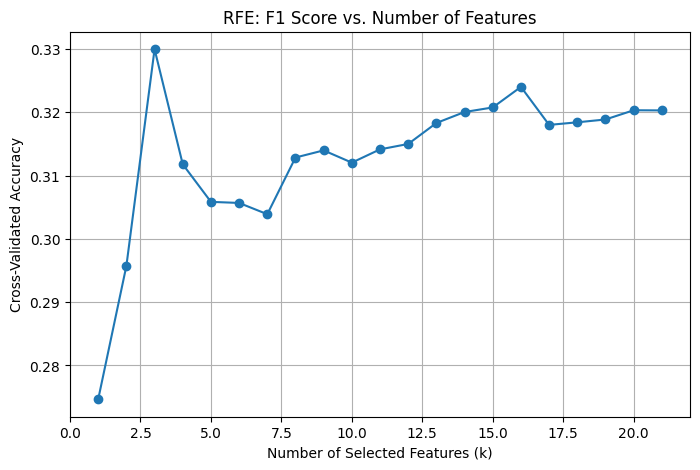

Best k = 3, F1 Score = 0.3300


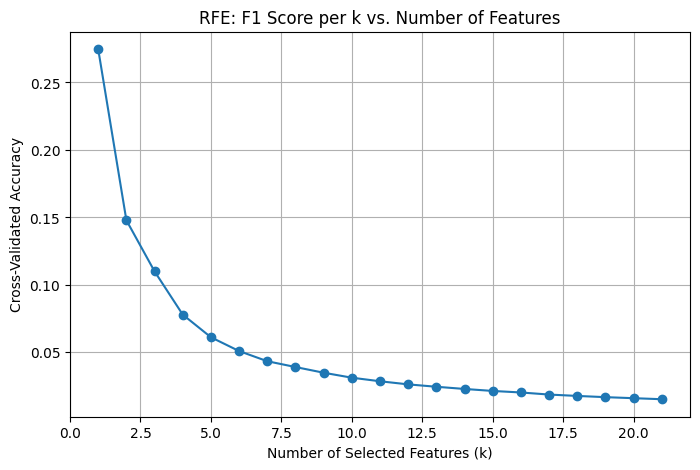

In [36]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

data = x_vif
y = data['Fraudulent']
X = data.drop(columns=['Fraudulent'])


model = RandomForestClassifier(random_state=42, class_weight='balanced')

k_range = range(1, X.shape[1])
cv_scores = []
cv_scores_per_k = []

for k in k_range:
    print(f"Currently doing {k} number of features")
    rfe = RFE(estimator=model, n_features_to_select=k)
    X_rfe = rfe.fit_transform(X, y)

    score = cross_val_score(model, X_rfe, y, cv=5, scoring='f1').mean()
    cv_scores.append(score)
    cv_scores_per_k.append(score/k)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("RFE: F1 Score vs. Number of Features")
plt.grid(True)
plt.show()

# Best k
best_k = k_range[cv_scores.index(max(cv_scores))]
print(f"Best k = {best_k}, F1 Score = {max(cv_scores):.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_range, cv_scores_per_k, marker='o')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("RFE: F1 Score per k vs. Number of Features")
plt.grid(True)
plt.show()



In [23]:
# pip install kneed

In [24]:
from kneed import KneeLocator

# Convert range to list if it's a range object
k_values = list(k_range)

# Detect elbow (knee) point
knee = KneeLocator(k_values, cv_scores_per_k, curve="convex", direction="decreasing")

print("Optimal number of features (elbow point):", knee.knee)

Optimal number of features (elbow point): 5


In [39]:
features = x_vif.drop(['Fraudulent'], axis=1).columns

score_df_k_best, selected_ftrs_k = feature_selection(x_vif, features, "select_rfe_with_class_weights", knee.knee)

In [40]:
selected_ftrs_k

array(['Comnpany_Logo', 'Experience_executive', 'Qualification_doctorate',
       "Qualification_master's degree",
       'Qualification_vocational / certification/ professional'],
      dtype=object)

In [41]:
embed_cols = []
for col in columns_for_embedding:
    embed_col_name = f"{col}_embed"
    embed_cols.append(embed_col_name)

selected_features = selected_ftrs_k.tolist() + embed_cols + ["Fraudulent"]
result_df = df_aft_enc[selected_features]

In [42]:
result_df.head(5)

,Comnpany_Logo,Experience_executive,Qualification_doctorate,Qualification_master's degree,Qualification_vocational / certification/ professional,Job Title_embed,Profile_embed,Department_embed,Job_Description_embed,Requirements_embed,Job_Benefits_embed,Type_of_Industry_embed,Operations_embed,City_embed,Fraudulent
0,1,0,0,0,0,"[-0.04586079, 0.021231126, 0.039720017, -0.015...","[0.0059326584, -0.116407596, -0.03926081, 0.05...","[-0.054775942, 0.019262953, -0.028039929, 0.00...","[-0.019716606, -0.15238602, -0.039701194, 0.07...","[0.022789469, -0.09116229, -0.028262809, 0.056...","[-0.06406343, -0.006899632, 0.044379856, -0.04...","[-0.010108503, 0.00017397602, -0.064525396, 0....","[-0.054775912, 0.019262949, -0.028039966, 0.00...","[0.08636304, -0.019883368, 0.071493715, 0.0488...",0
1,1,0,0,0,0,"[-0.11712625, 0.0027783148, -0.012937461, 0.04...","[-0.042393953, -0.05590628, -0.061733954, -0.0...","[-0.01010847, 0.0001739245, -0.0645254, 0.0444...","[-0.0069497214, -0.046861194, -0.005559732, -0...","[-0.02831424, -0.019446718, -0.09034293, -0.00...","[-0.06406343, -0.006899632, 0.044379856, -0.04...","[-0.010108504, 0.00017390934, -0.06452541, 0.0...","[-0.010108503, 0.00017397602, -0.064525396, 0....","[-0.08611439, 0.022029178, 0.013500442, -0.030...",0
2,1,0,0,0,0,"[0.0045969184, 0.004818055, 0.056100477, -0.01...","[0.050383907, -0.01683802, -0.017091345, 0.024...","[-0.069584936, 0.05052143, -0.051144898, -0.02...","[0.03736046, -0.062923715, -0.023061784, 0.017...","[0.017843384, -0.07715571, -0.055003617, 0.037...","[0.06099535, -0.09436665, -0.046824645, 0.0668...","[-0.07639083, 0.014425081, 0.007630127, -0.052...","[-0.06958498, 0.050521452, -0.05114485, -0.023...","[0.029875116, 0.072954565, 0.04196183, 0.06192...",0
3,1,0,0,0,0,"[-0.0777301, 0.04425556, -0.09833853, 0.036373...","[0.0010409413, -0.10610795, -0.046450004, 0.02...","[-0.010108504, 0.00017390934, -0.06452541, 0.0...","[-0.030644165, -0.025247702, -0.026902074, 0.0...","[-0.023004172, -0.072423175, -0.029025577, 0.0...","[0.01478068, 0.11605704, -0.014741847, -0.0080...","[-0.02402026, 0.0745743, 0.016253596, 0.028292...","[-0.08913744, 0.06874103, 0.037631404, 0.00796...","[0.067536786, -0.014432623, -0.051255368, 0.09...",0
4,0,0,0,0,0,"[-0.07389787, 0.0847628, -0.07173844, -0.00729...","[-0.0640634, -0.0068996837, 0.044379894, -0.04...","[-0.01010847, 0.0001739245, -0.0645254, 0.0444...","[-0.013112105, -0.034480955, -0.057782218, 0.0...","[-0.06406343, -0.006899632, 0.044379856, -0.04...","[-0.06406343, -0.006899632, 0.044379856, -0.04...","[-0.01010847, 0.0001739245, -0.0645254, 0.0444...","[-0.010108503, 0.00017397602, -0.064525396, 0....","[-0.010108503, 0.00017397602, -0.064525396, 0....",0


In [9]:
# result_df.to_csv("/content/drive/MyDrive/DSA4263-Project/eda_ftr_eng/df_before_modelling_new.csv")